### Imports

In [11]:
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from tensorflow.keras import Model
from tensorflow.keras.layers import (ConvLSTM2D, Dense, GlobalAveragePooling2D,
                                     Dropout, BatchNormalization)
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import numpy as np
import sys
import cv2
import tempfile
import os
import matplotlib.pyplot as plt
import argparse

In [12]:
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

### Modelo

In [13]:
CHECKPOINT_DIR = "./saved_models/i3d_convlstm_1/best_model"

In [14]:
# Mejores hiperparámetros ya definidos
best_hyperparameters = {
    'kernel_size': (3, 3),
    'filters': 128,
    'dropout': 0.3,
    'recurrent_dropout': 0.5,
    'dense_units': 128,
    'dense_dropout': 0.5
}

# --- LOAD MODEL
def load_model():
    def build_model():
        class Tuned_I3D_ConvLSTM(Model):
            def __init__(self, num_classes):
                super().__init__()
                self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint="Mixed_5c")

                # Usar los mejores hiperparámetros directamente
                kernel_size = best_hyperparameters['kernel_size']
                self.conv_lstm = ConvLSTM2D(
                    filters=best_hyperparameters['filters'],
                    kernel_size=kernel_size,
                    padding='same',
                    return_sequences=False,
                    dropout=best_hyperparameters['dropout'],
                    recurrent_dropout=best_hyperparameters['recurrent_dropout'],
                    activation='tanh'
                )

                self.batch_norm = BatchNormalization()
                self.dense = Dense(best_hyperparameters['dense_units'], activation='relu')
                self.dropout = Dropout(best_hyperparameters['dense_dropout'])
                self.fc = Dense(num_classes, activation='sigmoid')

            def call(self, inputs, training=False):
                features, _ = self.i3d(inputs)
                x = self.conv_lstm(features)
                x = self.batch_norm(x, training=training)
                x = GlobalAveragePooling2D()(x)
                x = self.dense(x)
                x = self.dropout(x, training=training)
                return self.fc(x)

        num_classes = 2
        model = Tuned_I3D_ConvLSTM(num_classes=num_classes)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
        return model
    
    model = build_model()

    # Cargar los pesos si es necesario
    model.load_weights(CHECKPOINT_DIR).expect_partial()

    return model

### Procesamiento

In [ ]:
import cv2
import numpy as np
import os
from IPython.display import display, clear_output
from PIL import Image
import time

NUM_FRAMES = 100
FRAME_SIZE = (224, 224)

def preprocess_video(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    step = max(1, total_frames // num_frames)
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame / 255.0)
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros((*frame_size, 3)))
    return np.expand_dims(np.array(frames, dtype=np.float32), axis=0)

def preprocess_frame(frame, frame_size=FRAME_SIZE):
    frame = cv2.resize(frame, frame_size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame / 255.0

def predict_crime(model, frames_window):
    input_tensor = np.expand_dims(np.array(frames_window, dtype=np.float32), axis=0)  # shape: (1, N_FRAMES, H, W, C)
    y_prob = model.predict(input_tensor)  # shape: (1, num_classes)
    
    predicted_class = np.argmax(y_prob, axis=1)[0]  # índice de la clase con mayor probabilidad
    crime_prob = y_prob[0][1]  # probabilidad de clase "crimen", que está en índice 1

    return predicted_class, crime_prob

def predict_crime2(model, video_tensor):
    prediction = model.predict(video_tensor)[0]
    predicted_class = np.argmax(prediction)
    return predicted_class

def simulate_realtime_from_video_notebook(video_path, model):
    cap = cv2.VideoCapture(video_path)
    buffer = []
    frame_count = 0
    print(f"\nAnalizando {video_path}...\n")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        preprocessed = preprocess_frame(frame)
        buffer.append(preprocessed)

        # Redimensionar para mostrar (sin normalizar ni convertir)
        display_frame = cv2.resize(frame, (640, 480))
        display_frame = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

        if len(buffer) == NUM_FRAMES:
            predicted_class, crime_prob = predict_crime(model, buffer)
            prob_crime = crime_prob * 100

            # Texto a mostrar
            text = f"Prob. crimen: {prob_crime:.2f}%"
            position = (10, 40)
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            thickness = 2
            text_color = (0, 0, 0)  # texto negro
            background_color = (255, 255, 255)  # fondo blanco

            # Obtener tamaño del texto
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)

            # Calcular esquinas del fondo
            top_left = (position[0] - 5, position[1] - text_height - baseline - 5)
            bottom_right = (position[0] + text_width + 5, position[1] + 5)

            # Dibujar fondo blanco con borde redondeado
            cv2.rectangle(display_frame, top_left, bottom_right, background_color, cv2.FILLED)
            cv2.rectangle(display_frame, top_left, bottom_right, (200, 200, 200), 1)  # borde gris claro

            # Dibujar texto
            cv2.putText(display_frame, text, position, font, font_scale, text_color, thickness, cv2.LINE_AA)

            buffer.pop(0)  # mantener tamaño ventana

        # Mostrar en notebook
        if frame_count % NUM_FRAMES / 2 == 0:
            clear_output(wait=True)
            display(Image.fromarray(display_frame))
        #time.sleep(0.001)  # simular tiempo real (100 fps)

        frame_count += 1

    cap.release()

def analyze_static_videos(video_path, model):
    video_tensor = preprocess_video(video_path)
    predicted_class = predict_crime2(model, video_tensor) 
    class_labels = ["No crimen", "Crimen"]


    label = class_labels[predicted_class]
    confidence = f"{100 * model.predict(video_tensor)[0][predicted_class]:.2f}%"

    print('--' * 50)
    print(f"Resultado: {label}")
    print(f"Confianza: {confidence}")
    print('--' * 50)

### Demo

In [16]:
print("Cargando modelo...")
model = load_model()

Cargando modelo...


In [28]:
video_dir = "./videos"
video_files = [f for f in os.listdir(video_dir) if f.endswith((".mp4", ".avi"))]

if len(video_files) < 2:
    print("Se necesitan al menos dos videos en la carpeta /videos.")

# Analizar videos estáticos
for video_file in video_files:
    print(f"\nAnalizando video: {video_file}")
    video_path = os.path.join(video_dir, video_file)
    analyze_static_videos(video_path, model)


Analizando video: Arson020_x264.mp4
----------------------------------------------------------------------------------------------------
Resultado: Crimen
Confianza: 69.46%
----------------------------------------------------------------------------------------------------

Analizando video: Robbery053_x264.mp4
----------------------------------------------------------------------------------------------------
Resultado: Crimen
Confianza: 81.48%
----------------------------------------------------------------------------------------------------


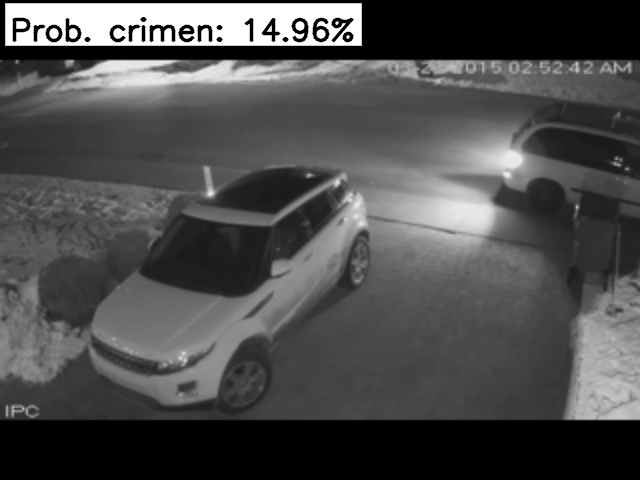

KeyboardInterrupt: 

In [29]:
for video_file in video_files:
    print(f"\nAnalizando video: {video_file}")
    video_path = os.path.join(video_dir, video_file)
    simulate_realtime_from_video_notebook(video_path, model)